In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

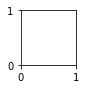

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Load data

In [6]:
df_sec = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm.csv')
df_swath = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')

df_all = df_sec.merge(df_swath, how='outer')

df_plot = df_all.drop(columns=['accn', 'name'])
df_plot = df_plot.fillna(0)
df_plot = np.log10(df_plot)
df_plot.replace(-1*np.inf, np.nan, inplace=True)

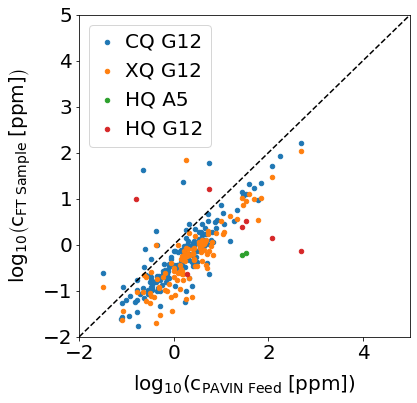

In [8]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{log_{10}\left( c_{PAVIN \; Feed} \; [ppm] \right)}$', 
                                  ylabel=r'$\mathsf{log_{10}\left( c_{FT \; Sample} \; [ppm] \right)}$', x=6.2, y=6)

ax.scatter(df_plot.pavin_feed, df_plot.cq_g12, label='CQ G12', s=20)
ax.scatter(df_plot.pavin_feed, df_plot.xq_g12, label='XQ G12', s=20)
ax.scatter(df_plot.pavin_feed, df_plot.hq_a5, label='HQ A5', s=20)
ax.scatter(df_plot.pavin_feed, df_plot.hq_g12, label='HQ G12', s=20)

vals = [-2, 5]
ax.set_xlim(vals)
ax.set_ylim(vals)
ax.plot(vals, vals, 'k--')

my_plot.set_layout(fig, ax, legend=True, frameon=True, loc='upper left', handletextpad=0.4)
plt.savefig('./images/9_c_sample_vs_c_feed.png', dpi=300)

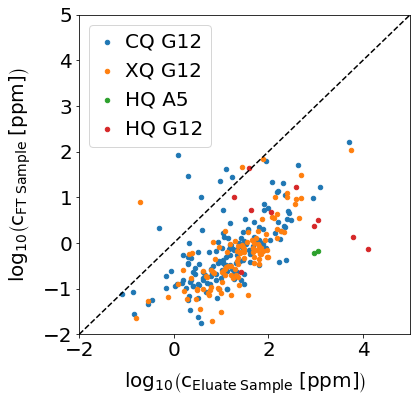

In [131]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{log_{10}\left( c_{Eluate \; Sample} \; [ppm] \right)}$', 
                                  ylabel=r'$\mathsf{log_{10}\left( c_{FT \; Sample} \; [ppm] \right)}$', x=6.2, y=6)

ax.scatter(df_plot.cq_eluate, df_plot.cq_g12, label='CQ G12', s=20)
ax.scatter(df_plot.xq_eluate, df_plot.xq_g12, label='XQ G12', s=20)
ax.scatter(df_plot.hq_eluate, df_plot.hq_a5, label='HQ A5', s=20)
ax.scatter(df_plot.hq_eluate, df_plot.hq_g12, label='HQ G12', s=20)

vals = [-2, 5]
ax.set_xlim(vals)
ax.set_ylim(vals)
ax.plot(vals, vals, 'k--')

my_plot.set_layout(fig, ax, legend=True, frameon=True, loc='upper left', handletextpad=0.4)
plt.savefig('./images/9_c_ft_vs_c_eluate.png', dpi=300)

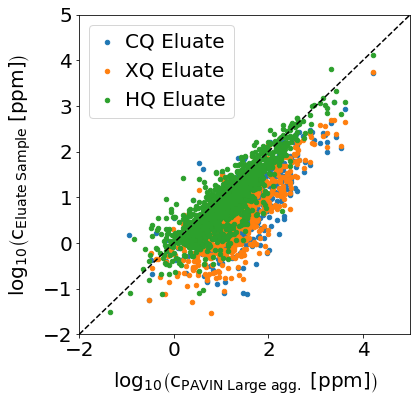

In [129]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{log_{10}\left( c_{PAVIN \; Large \; agg.} \; [ppm] \right)}$', 
                                  ylabel=r'$\mathsf{log_{10}\left( c_{Eluate \; Sample} \; [ppm] \right)}$', x=6.2, y=6)

ax.scatter(df_plot.pavin_large, df_plot.cq_eluate, label='CQ Eluate', s=20)
ax.scatter(df_plot.pavin_large, df_plot.xq_eluate, label='XQ Eluate', s=20)
ax.scatter(df_plot.pavin_large, df_plot.hq_eluate, label='HQ Eluate', s=20)

vals = [-2, 5]
ax.set_xlim(vals)
ax.set_ylim(vals)
ax.plot(vals, vals, 'k--')

my_plot.set_layout(fig, ax, legend=True, frameon=True, loc='upper left', handletextpad=0.4)
plt.savefig('./images/9_c_eluate_vs_c_large_agg.png', dpi=300)

# Investigation

In [7]:
df_all = df_all.fillna(0)
df_hq_ft = df_all[df_all.hq_g12 > 0].copy()
df_hq_ft = df_hq_ft[['accn', 'name', 'hq_a5', 'hq_g12']]
df_hq_ft.sort_values(by=['hq_g12', 'hq_a5'], inplace=True, ascending=False)
df_hq_ft.reset_index(drop=True, inplace=True)
df_hq_ft.to_csv('./generated_tables/investigation_hq_g12_vs_hq_a5.csv', index=False)

In [8]:
# df_hq_ft

In [9]:
df_all[df_all.accn == 'XP_027244002.1'].to_csv('./generated_tables/investigation_debrin.csv', index=False)
df_all[df_all.accn == 'XP_027244002.1']

,accn,name,hccf_feed,hccf_large,hccf_small,hccf_mab,hccf_spf1,hccf_spf2,pavin_feed,pavin_large,pavin_small,pavin_mab,cq_g12,cq_eluate,hq_a5,hq_g12,hq_eluate,xq_g12,xq_eluate
109,XP_027244002.1,drebrin-like protein isoform X2 [Cricetulus gr...,0.54234,0.0,0.0,0.113323,0.455849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348.463664,0.0,0.0,0.0


How many species were observed in the AEX samples that weren't detected in the PAVIN SEC fractions?

In [12]:
df_fn = df_all[((df_all.cq_g12 > 0.0) | (df_all.cq_eluate > 0.0) | (df_all.hq_a5 > 0.0) | (df_all.hq_g12 > 0.0) | (df_all.hq_eluate > 0.0) | (df_all.xq_g12 > 0.0) | (df_all.xq_eluate > 0.0)) &
               ((df_all.pavin_feed == 0.0) & (df_all.pavin_large == 0.0) & (df_all.pavin_small == 0.0) & (df_all.pavin_mab == 0.0))].copy()
df_fn['aex_sum'] = df_all.cq_g12 + df_all.cq_eluate + df_all.hq_a5 + df_all.hq_g12 + df_all.hq_eluate + df_all.xq_g12 + df_all.xq_eluate
df_fn.sort_values(by=['aex_sum'], inplace=True, ascending=False)
df_fn.reset_index(inplace=True, drop=True)
df_fn.to_csv('./generated_tables/investigation_sec_false_negatives.csv', index=False)

In [13]:
# df_fn

In [14]:
df_fn_in_sec = df_sec[((df_sec.pavin_feed > 0.0) | (df_sec.pavin_large > 0.0) | (df_sec.pavin_small > 0.0) | (df_sec.pavin_mab > 0.0)) & 
                      ((df_sec.hccf_feed == 0.0) & (df_sec.hccf_large == 0.0) & (df_sec.hccf_small == 0.0) & (df_sec.hccf_mab == 0.0) & (df_sec.hccf_spf1 == 0.0) & (df_sec.hccf_spf2 == 0.0))].copy()
df_fn_in_sec.reset_index(drop=True, inplace=True)
# Only in pavin large and small

In [45]:
label = r'$\mathsf{c_{HCP}}$ [ppm = ng HCP / mg total]'
log10_label = r'$\mathsf{log_{10}\left(c_{HCP} \; [ppm \; = \; ng \; HCP \; / \; mg \; total]\right)}$'

frac_name_dic = {'pavin_large':'PAVIN Large Agg.',
                 'pavin_small':'PAVIN Small Agg.',
                 'cq_g12':'Capto Q G12',
                 'cq_eluate':'Capto Q Eluate',
                 'hq_a5':'Poros 50 HQ A5',
                 'hq_g12':'Poros 50 HQ G12',
                 'hq_eluate':'Poros 50 HQ Eluate',
                 'xq_g12':'Poros XQ G12',
                 'xq_eluate':'Poros XQ Eluate'}

for sample in ['pavin_large', 'pavin_small']:
    df_temp = pd.DataFrame()
    df_temp[label] = df_fn_in_sec[df_fn_in_sec[sample] > 0.0][sample]
    df_temp['sample'] = frac_name_dic[sample]
    if sample == 'pavin_large':
        df_plot = df_temp.copy()
    else:
        df_plot = pd.concat([df_plot, df_temp], ignore_index=True)
    
for sample in ['cq_g12', 'cq_eluate', 'hq_a5', 'hq_g12', 'hq_eluate', 'xq_g12', 'xq_eluate']:
    df_temp = pd.DataFrame()
    df_temp[label] = df_fn[df_fn[sample] > 0.0][sample]
    df_temp['sample'] = frac_name_dic[sample]
    df_plot = pd.concat([df_plot, df_temp], ignore_index=True)
    
df_plot[log10_label] = np.log10(df_plot[label])

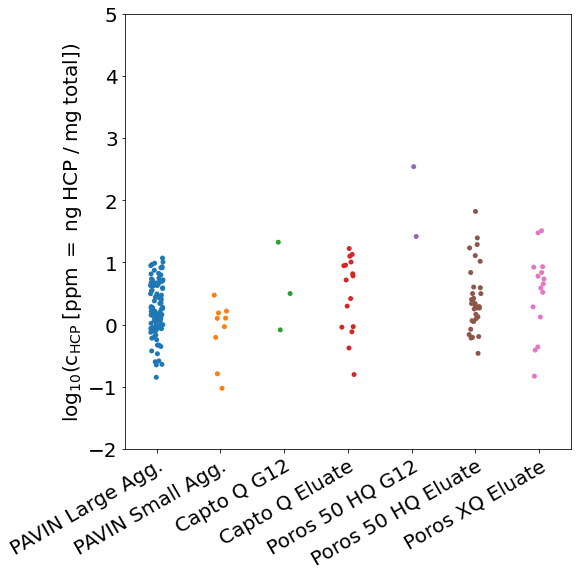

In [54]:
plt.gcf().set_size_inches(8, 8)
ax = sns.stripplot(x="sample", y=log10_label, data=df_plot, jitter=True)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
lim = ax.set_ylim(-2, 5)
plt.savefig('./images/9_investigation_concentration_of_false_negatives.png', dpi=300, bbox_inches='tight')

In [49]:
vals_sec = []
for frac in ['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_spf1', 'hccf_spf2', 'pavin_feed', 'pavin_large', 'pavin_small', 'pavin_mab']:
    vals_sec += list(df_sec[frac])

vals_aex = []
for frac in ['cq_g12', 'cq_eluate', 'hq_a5', 'hq_g12', 'hq_eluate', 'xq_g12', 'xq_eluate']:
    vals_aex += list(df_swath[frac])
    
df_plot_ref = pd.DataFrame({label:[i for i in vals_sec if i > 0.0], 'sample':['All HCCF / PAVIN SEC Fractions' for i in vals_sec if i > 0.0]})
df_temp = pd.DataFrame({label:[i for i in vals_aex if i > 0.0], 'sample':['All AEX Samples' for i in vals_aex if i > 0.0]})
df_plot_ref = pd.concat([df_plot_ref, df_temp], ignore_index=True)

df_plot_ref[log10_label] = np.log10(df_plot_ref[label])

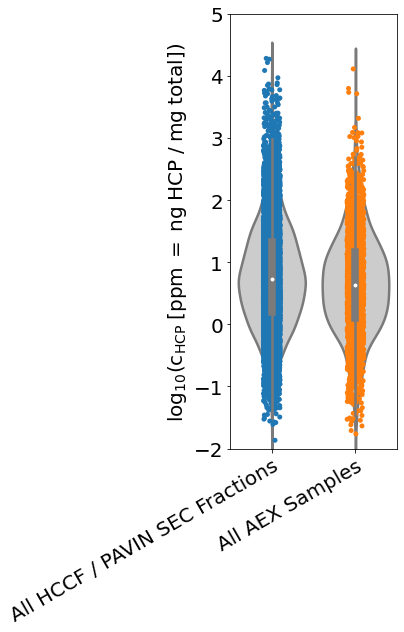

In [53]:
plt.gcf().set_size_inches(3, 8)
ax = sns.violinplot(x="sample", y=log10_label, data=df_plot_ref, color=".8", linewidth=2.5, width=0.8)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x="sample", y=log10_label, data=df_plot_ref, jitter=True)

labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
lim = ax.set_ylim(-2, 5)
plt.savefig('./images/9_investigation_concentration_ref_all_swath_data.png', dpi=300, bbox_inches='tight')